In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import keras
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

!pip install -q -U keras-tuner
import kerastuner as kt

import IPython


from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import re

from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

from IPython.display import display 

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import sys
sys.path.append("../..")


from src.model_evaluation import *
from src.data_preprocessing import *

sns.set(context = 'notebook', style = 'whitegrid')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Preprocessing 

In [108]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/flatiron_project_4/judge-1377884607_tweet_product_company.csv',
            encoding = 'latin1')
df = df_clean(df)

/content/src/data_preprocessing.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)
/content/src/data_preprocessing.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_product'] = df.apply(lambda x: list([x['text'], x['product']]), axis = 1)
/content/src/data_preprocessing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [111]:
sequence_len = 128

X = df['txt_cleaned']
y = df['emotion']

encoder = LabelEncoder()
tokenizer = text.Tokenizer()
sm = SMOTE()

#Encode Labels
y = pd.DataFrame(encoder.fit_transform(y))

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.25)

#tokenize full X_train
tokenizer.fit_on_texts(list(X_train))
list_tokenized_headlines = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

#Tokenize training X
tokenized_X_t = tokenizer.texts_to_sequences(X_t)
X_t = sequence.pad_sequences(tokenized_X_t, maxlen=128)

#Tokenize validation
tokenized_X_val = tokenizer.texts_to_sequences(X_val)
X_val = sequence.pad_sequences(tokenized_X_val, maxlen=128)

#Tokenize hold out set
tokenized_X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_X_test, maxlen=128)

#Create SMOTE'd version of X_t
X_t_res, y_t_res = sm.fit_sample(X_t,y_t)
X_train_res, y_train_res = sm.fit_sample(X_train,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

## Model 1
RNN First Simple Model, no SMOTE

In [110]:
def make_model1():
    embedding_size = 128
    model1 = Sequential()
    model1.add(Embedding(len(tokenizer.word_index.keys())+1, sequence_len))
    model1.add(LSTM(25, return_sequences=True))
    model1.add(GlobalMaxPool1D())
    model1.add(Dropout(0.5))
    model1.add(Dense(50, activation='relu'))
    model1.add(Dropout(0.5))
    model1.add(Dense(3, activation='softmax'))

    model1.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model1

Epoch 1/65
37/37 [==============================] - 2s 45ms/step - loss: 0.7496 - acc: 0.7675 - val_loss: 0.5533 - val_acc: 0.8182
Epoch 2/65
37/37 [==============================] - 1s 32ms/step - loss: 0.6370 - acc: 0.8087 - val_loss: 0.5439 - val_acc: 0.8182
Epoch 3/65
37/37 [==============================] - 1s 33ms/step - loss: 0.6129 - acc: 0.8098 - val_loss: 0.5306 - val_acc: 0.8182
Epoch 4/65
37/37 [==============================] - 1s 32ms/step - loss: 0.5592 - acc: 0.8108 - val_loss: 0.5073 - val_acc: 0.8182
Epoch 5/65
37/37 [==============================] - 1s 33ms/step - loss: 0.4845 - acc: 0.8114 - val_loss: 0.4721 - val_acc: 0.8182
Epoch 6/65
37/37 [==============================] - 1s 33ms/step - loss: 0.4112 - acc: 0.8184 - val_loss: 0.5000 - val_acc: 0.8247
Epoch 7/65
37/37 [==============================] - 1s 32ms/step - loss: 0.3525 - acc: 0.8488 - val_loss: 0.5423 - val_acc: 0.8425
Epoch 8/65
37/37 [==============================] - 1s 32ms/step - loss: 0.3080 - a

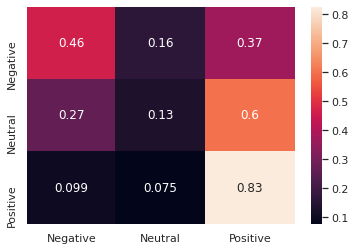

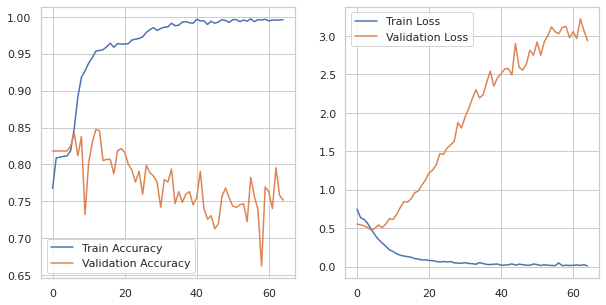

model validation accuracy is: 0.7516233766233766


In [74]:
model1 = KerasClassifier(build_fn = make_model1, 
                           epochs = 65, 
                           batch_size = 50, 
                           validation_data = (X_val,y_val))

history = model1.fit(X_t, y_t)
y_pred = model1.predict(X_val)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val,y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val,y_pred)}')

### Model 1 Evaluation
Model 1 overfits after 11 epochs.  It reaches 67% accuracy on the validation set at the point.  It struggles to classify negative emotions, and to a lesser degree positives.  Because of the class imbalance skewed toward no emotion, it overpredicts this class.

## Model 2
for model 2 I will try the same as model 1, but with SMOTED class balances.

In [114]:
def make_model2():
    embedding_size = 128
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index.keys())+1, sequence_len))
    model.add(LSTM(25, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

Epoch 1/50
90/90 [==============================] - 3s 35ms/step - loss: 1.0909 - acc: 0.3846 - val_loss: 0.9948 - val_acc: 0.6558
Epoch 2/50
90/90 [==============================] - 3s 31ms/step - loss: 1.0453 - acc: 0.4643 - val_loss: 0.9458 - val_acc: 0.6737
Epoch 3/50
90/90 [==============================] - 3s 31ms/step - loss: 0.9750 - acc: 0.5094 - val_loss: 0.9001 - val_acc: 0.6737
Epoch 4/50
90/90 [==============================] - 3s 31ms/step - loss: 0.9020 - acc: 0.5577 - val_loss: 0.9561 - val_acc: 0.6542
Epoch 5/50
90/90 [==============================] - 3s 30ms/step - loss: 0.8372 - acc: 0.6078 - val_loss: 0.8577 - val_acc: 0.7045
Epoch 6/50
90/90 [==============================] - 3s 31ms/step - loss: 0.7640 - acc: 0.6506 - val_loss: 0.9046 - val_acc: 0.6916
Epoch 7/50
90/90 [==============================] - 3s 30ms/step - loss: 0.7072 - acc: 0.6832 - val_loss: 1.1024 - val_acc: 0.6201
Epoch 8/50
90/90 [==============================] - 3s 30ms/step - loss: 0.6382 - a

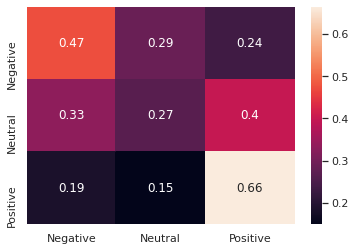

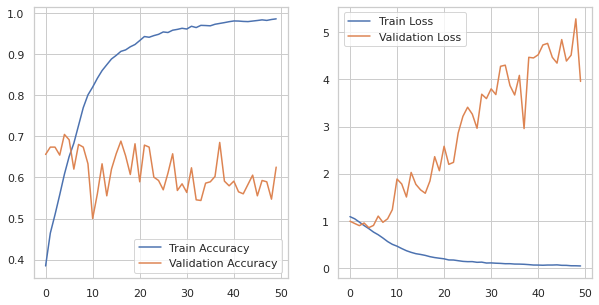

model validation accuracy is: 0.625


In [115]:
model2 = KerasClassifier(build_fn = make_model2, 
                         epochs = 50, 
                         batch_size = 50, 
                         validation_data = (X_val,y_val))
history = model2.fit(X_t_res, y_t_res)
y_pred = model2.predict(X_val)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val,y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val,y_pred)}')

### Model 2 Evaluation:
Model 2 begins overfitting at about 6 epochs.  The overall accuracy is lower, but the true positive rates are more balanced between the classes.  False positives are still high for no emotion

# Model 3
In this model we will try using GloVe embeddings instead of a learned embedding layer
Relying heavily on fchollet at https://keras.io/examples/nlp/pretrained_word_embeddings/

### New Train test split

### Initialize the vectorizor, create the vocabulary, and create the word index

### Get pretrained embeddings from the GloVe model.

### Create the embedding matrix to act as the weights for the new embedding layer

revectorize the data for use with the custom embedding layer with the trained Vectorizer.

In [102]:
X_train_2, X_test_2, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t_2, X_val_2, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.25)

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=50)
text_ds = tf.data.Dataset.from_tensor_slices(X)
vectorizer.adapt(text_ds)
total_vocabulary = set(vectorizer.get_vocabulary())

print(f'total vocabulary length: {len(total_vocabulary)}')
word_index = dict(zip(total_vocabulary, range(len(total_vocabulary))))

from gensim.models import word2vec

glove = {}
with open('/content/drive/My Drive/Colab Notebooks/flatiron_project_4/glove.6B/glove.6B.50d.txt',
          'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype = np.float32)
            glove[word] = vector


num_tokens = len(total_vocabulary) + 2
embedding_dim = 50
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits +=1
    else:
        misses += 1
print(f'converted {hits} words ({misses} misses)')
    

X_t_glove = vectorizer(np.array([[s] for s in X_t_2])).numpy()
X_val_glove = vectorizer(np.array([[s] for s in X_val_2])).numpy()
X_test_glove = vectorizer(np.array([[s] for s in X_test_2])).numpy()
X_train_glove = vectorizer(np.array([[s] for s in X_train_2])).numpy()

X_t_glove_res, y_t_res = sm.fit_sample(X_t_glove,y_t)


total vocabulary length: 5042
converted 3803 words (1239 misses)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [84]:
def make_model3():
    from tensorflow.keras import regularizers

    model = Sequential()

    embedding_layer = layers.Embedding(
                        num_tokens,
                        embedding_dim,
                        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                        trainable = True
                                )
    model.add(embedding_layer)
    model.add(LSTM(50, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

### Train the model

Epoch 1/65
90/90 [==============================] - 2s 26ms/step - loss: 1.1522 - acc: 0.3238 - val_loss: 1.1191 - val_acc: 0.8182
Epoch 2/65
90/90 [==============================] - 2s 20ms/step - loss: 1.1368 - acc: 0.3492 - val_loss: 1.1200 - val_acc: 0.7760
Epoch 3/65
90/90 [==============================] - 2s 20ms/step - loss: 1.1333 - acc: 0.3650 - val_loss: 1.0995 - val_acc: 0.8166
Epoch 4/65
90/90 [==============================] - 2s 20ms/step - loss: 1.1161 - acc: 0.3993 - val_loss: 1.0484 - val_acc: 0.8166
Epoch 5/65
90/90 [==============================] - 2s 20ms/step - loss: 1.0750 - acc: 0.4557 - val_loss: 0.9466 - val_acc: 0.8036
Epoch 6/65
90/90 [==============================] - 2s 20ms/step - loss: 1.0327 - acc: 0.4860 - val_loss: 0.8708 - val_acc: 0.8198
Epoch 7/65
90/90 [==============================] - 2s 20ms/step - loss: 0.9797 - acc: 0.5085 - val_loss: 0.7762 - val_acc: 0.8247
Epoch 8/65
90/90 [==============================] - 2s 20ms/step - loss: 0.9343 - a

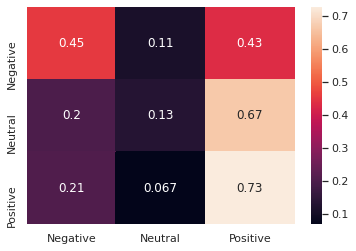

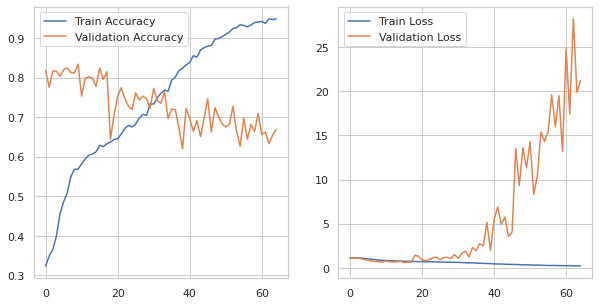

model validation accuracy is: 0.6688311688311688


In [85]:
import keras

model3 = make_model3()
history = model3.fit(X_t_glove_res, y_t_res, 
                     epochs = 65, 
                     batch_size = 50, 
                     validation_data = (X_val_glove, y_val)
                     )
y_pred = model3.predict(X_val_glove)
y_pred = np.argmax(y_pred, axis = 1).reshape(-1,1)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val, y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val, y_pred)}')

## Model 3 Evaluation:
Model 3 used pretrained weights from the GloVe embedding model to initialize it's embedding layer weights, but also allowed them to be further trained.  It overfit on the training data and achieved  50% accuracy.  However, it's errors were distributed across classes, rather than the model just guessing that all responses are positive.  I actually see this as an improvement.  I believe that the model needs more data, and more balanced data to make further significant progress.

### Model 4 
with this model we will add regularization to improve try to improve validation accuracy.

In [70]:
class ClearTrainingOutput(tensorflow.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [86]:
def make_model4():
    from tensorflow.keras import regularizers

    model = Sequential()

    embedding_layer = layers.Embedding(
                        num_tokens,
                        embedding_dim,
                        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                        trainable = True
                                )
    model.add(embedding_layer)
    model.add(LSTM(75, 
                   return_sequences=True
                   ))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(0.6))
 
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model



Epoch 1/100
90/90 [==============================] - 2s 27ms/step - loss: 1.5864 - acc: 0.3211 - val_loss: 1.3380 - val_acc: 0.5260
Epoch 2/100
90/90 [==============================] - 2s 21ms/step - loss: 1.4243 - acc: 0.3367 - val_loss: 1.3428 - val_acc: 0.4026
Epoch 3/100
90/90 [==============================] - 2s 22ms/step - loss: 1.3747 - acc: 0.3385 - val_loss: 1.3352 - val_acc: 0.2143
Epoch 4/100
90/90 [==============================] - 2s 22ms/step - loss: 1.3466 - acc: 0.3362 - val_loss: 1.3126 - val_acc: 0.4854
Epoch 5/100
90/90 [==============================] - 2s 21ms/step - loss: 1.3273 - acc: 0.3320 - val_loss: 1.2923 - val_acc: 0.6753
Epoch 6/100
90/90 [==============================] - 2s 22ms/step - loss: 1.3078 - acc: 0.3396 - val_loss: 1.3039 - val_acc: 0.2029
Epoch 7/100
90/90 [==============================] - 2s 21ms/step - loss: 1.2855 - acc: 0.3676 - val_loss: 1.2899 - val_acc: 0.4123
Epoch 8/100
90/90 [==============================] - 2s 22ms/step - loss: 1.

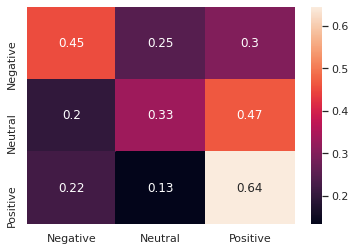

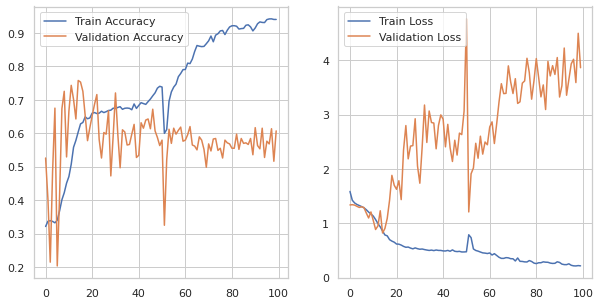

model validation accuracy is: 0.6071428571428571


In [87]:
model4 = make_model4()
history = model4.fit(X_t_glove_res, y_t_res, 
                     epochs = 100, 
                     batch_size = 50, 
                     validation_data = (X_val_glove, y_val)
                     )
y_pred = model4.predict(X_val_glove)
y_pred = np.argmax(y_pred, axis = 1).reshape(-1,1)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val, y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val, y_pred)}')

### Model 4 Evaluation
Model 4 had about the same total accuracy as model 3, but it increased it's true positives for negative and neutral classes.  This shows me that the model is continuing to differentiate between classes successfully, showing a slightly more balanced distribution of mistakes than model 3.  Whereas model 2 had a higher overall accuracy, it failed to successfully learn the neutral class and tended to bucket most tweets into positive or negative.  Model 4 considers each class with less bias.

## Model 5
In model 5 I will introduce Keras Tuner to search for appropriate hyperparameters, neurons for the LSTM layer, neurons for the dense layers, and rate of dropout for the dropout layers.

In [88]:
def make_model5(hp):
    from tensorflow.keras import regularizers

    model = Sequential()



    embedding_layer = layers.Embedding(
                        num_tokens,
                        embedding_dim,
                        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                        trainable = hp.Choice('trainable', values = [True, False])
                                )
    model.add(embedding_layer)
    model.add(LSTM(units = hp.Int('LSTM_units', min_value = 80, max_value = 200, step = 20), 
                   return_sequences=True
                   ))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('units', min_value = 100, max_value = 200, step = 20), 
                    activation=hp.Choice('activation',values = ['tanh','relu']), 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('units', min_value = 100, max_value = 200, step = 20), 
                    activation=hp.Choice('activation',values = ['tanh','relu']), 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('units', min_value = 100, max_value = 200, step = 20), 
                    activation=hp.Choice('activation',values = ['tanh','relu']), 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))   
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('units', min_value = 100, max_value = 200, step = 20), 
                    activation=hp.Choice('activation',values = ['tanh','relu']), 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))   
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))
 
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

In [89]:
tuner = kt.Hyperband(make_model5,
                     objective = 'val_acc',
                     max_epochs = 10,
                     factor = 10,
                     directory = '/content/drive/My Drive/Colab Notebooks/flatiron_project_4',
                     project_name = 'NLP_phase_4_flatiron4')


#tuner.search(X_t_glove_res, y_t_res, epochs = 10, validation_data = (X_val_glove, y_val), callbacks = [ClearTrainingOutput()])
best_hps = tuner.get_best_hyperparameters(num_trials = 10)[0]
best_hps.get('units')
model5 = tuner.hypermodel.build(best_hps)
model5.summary()

INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/Colab Notebooks/flatiron_project_4/NLP_phase_4_flatiron4/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/Colab Notebooks/flatiron_project_4/NLP_phase_4_flatiron4/tuner0.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          252200    
_________________________________________________________________
lstm (LSTM)                  (None, None, 200)         200800    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 140)  

Epoch 1/100
90/90 [==============================] - 3s 35ms/step - loss: 1.6924 - acc: 0.3224 - val_loss: 1.5956 - val_acc: 0.8182
Epoch 2/100
90/90 [==============================] - 3s 28ms/step - loss: 1.5553 - acc: 0.3431 - val_loss: 1.4708 - val_acc: 0.8182
Epoch 3/100
90/90 [==============================] - 3s 28ms/step - loss: 1.4434 - acc: 0.3752 - val_loss: 1.3725 - val_acc: 0.6591
Epoch 4/100
90/90 [==============================] - 3s 29ms/step - loss: 1.3137 - acc: 0.4430 - val_loss: 1.2353 - val_acc: 0.7338
Epoch 5/100
90/90 [==============================] - 3s 28ms/step - loss: 1.2085 - acc: 0.4918 - val_loss: 1.0369 - val_acc: 0.8117
Epoch 6/100
90/90 [==============================] - 3s 28ms/step - loss: 1.1088 - acc: 0.5305 - val_loss: 0.9481 - val_acc: 0.7581
Epoch 7/100
90/90 [==============================] - 3s 29ms/step - loss: 1.0193 - acc: 0.5457 - val_loss: 0.9547 - val_acc: 0.7500
Epoch 8/100
90/90 [==============================] - 3s 28ms/step - loss: 0.

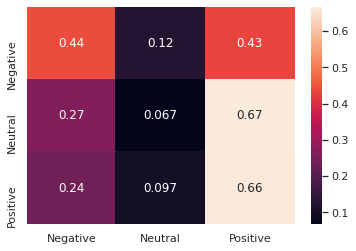

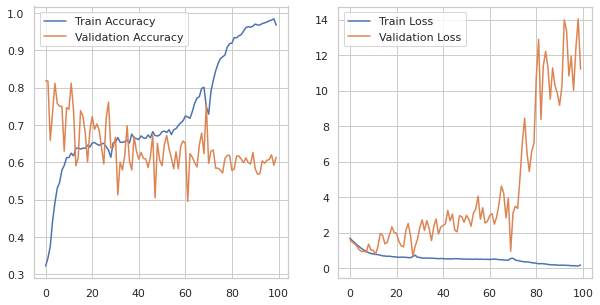

model validation accuracy is: 0.6136363636363636


In [90]:
history = model5.fit(X_t_glove_res, y_t_res, 
                     epochs = 100, 
                     batch_size = 50, 
                     validation_data = (X_val_glove, y_val)
                     )
y_pred = model5.predict(X_val_glove)
y_pred = np.argmax(y_pred, axis = 1).reshape(-1,1)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val, y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val, y_pred)}')

## Model 5 Evaluation
Model 5 is the largest of the models so far.  The Keras hyperparameter tuner has chosen a larger number of neurons per layer than I had previously tried, suggesting that my model needs more computational power.  In my next model I will try a search over a larger number of node possibilies.  I have set each dense layer to have the same number of nodes to reduce search space, but I will try allowing them to have different numbers of nodes next.  Another interesting observation is that the tuner has chosen to allow the pre-trained embedding layer to be further trained, rather than accepting the GloVe embeddings.

This model spreads its errors out, so it is not stuck in the assumption that all sentiments are positive, due to the imbalance in classes.  

Another change I would like to try is to base the tuner on maximizing the train accuracy rather than the validation accuracy.  Since the validation set has severe class imbalance, this may be biasing the search algorithm toward biased models.

## Model 6
Model 6 will be like mode 5, but allow the tuner to additionally choose separate weights for each layer, choose the optimizer, and give it a higher range of possible weights for the LSTM layer, since it chose the maximum in Model 5.  Finally, I will set the tuner to optimize accuracy on the training set, since it has a better class balance.  Bias toward positive sentiment allows the model to reach 80+% accuracy without truly learning to differentiate sentiments.

In [91]:
def make_model6(hp):

    model = Sequential()
    embedding_layer = layers.Embedding(
                        num_tokens,
                        embedding_dim,
                        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                        trainable = hp.Choice('trainable', values = [True, False])
                                )
    model.add(embedding_layer)
    model.add(LSTM(units = hp.Int('LSTM_units', min_value = 200, max_value = 400, step = 40), 
                   return_sequences=True
                   ))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('layer_3_units', min_value = 100, max_value = 200, step = 20), 
                    activation=hp.Choice('activation',values = ['tanh','relu']), 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('layer_4_units', min_value = 100, max_value = 200, step = 20), 
                    activation=hp.Choice('activation',values = ['tanh','relu']), 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('layer_5_units_2', min_value = 100, max_value = 200, step = 20), 
                    activation=hp.Choice('activation',values = ['tanh','relu']), 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))   
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('layer_6_units', min_value = 100, max_value = 200, step = 20), 
                    activation=hp.Choice('activation',values = ['tanh','relu']), 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))   
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))
 
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = hp.Choice('optimizer',['adam','rmsprop']), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model



In [99]:
tuner = kt.Hyperband(make_model6,
                     objective = 'acc',
                     max_epochs = 10,
                     factor = 10,
                     directory = '/content/drive/My Drive/Colab Notebooks/flatiron_project_4/tuner_model_6',
                     project_name = 'NLP_phase_4_model_6')

tuner.search(X_t_glove_res, y_t_res, epochs = 10, validation_data = (X_val_glove, y_val), callbacks = [ClearTrainingOutput()])


best_hps = tuner.get_best_hyperparameters(num_trials = 10)[0]
model6 = tuner.hypermodel.build(best_hps)
IPython.display.display(model6.summary())
print(f'Optimizer chose: {best_hps.get("optimizer")}')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          252200    
_________________________________________________________________
lstm (LSTM)                  (None, None, 320)         474880    
_________________________________________________________________
global_max_pooling1d (Global (None, 320)               0         
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               64200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               3

None

Optimizer chose: rmsprop


In [ ]:

history = model6.fit(X_t_glove_res, y_t_res, 
                     epochs = 100, 
                     batch_size = 50, 
                     validation_data = (X_val_glove, y_val)
                     )
y_pred = model6.predict(X_val_glove)
y_pred = np.argmax(y_pred, axis = 1).reshape(-1,1)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val, y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val, y_pred)}')

### Model 6 Evaluation:
model 6 is not a significant improvement over previous models.

##Final Model:
In all, Model 1 got the best accuracy, but model 2 learned to do a little better on more classes.  We had some luck with the keras tuner, so I'm going to finish this experiment by mixing them all a little.  I'll use the small network from model 1, the smoted data from model 2, and a keras tuner to tune the hyper parameters.

In [123]:
def make_model_final(hp):
    embedding_size = 128
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index.keys())+1, sequence_len))
    model.add(LSTM(units = hp.Int('LSTM_units', 
                                  min_value = 200, 
                                  max_value = 400, 
                                  step = 40), 
                   return_sequences=True)
                   )
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate = hp.Float('dropout_1_rate',min_value = 0.2, max_value = 0.8)))
    model.add(Dense(units = hp.Int('dense_units', 
                                   min_value = 50, 
                                   max_value = 200,
                                   step = 25),
                    activation=hp.Choice('dense_activation',['relu','tanh'])))
    model.add(Dropout(rate = hp.Float('dropout_2_rate',min_value = 0.2, max_value = 0.8)))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = hp.Choice('activaton',['rmsprop','adam']), 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['acc'])

    return model

In [125]:
tuner = kt.Hyperband(make_model_final,
                     objective = 'acc',
                     max_epochs = 25,
                     factor = 5,
                     directory = '/content/drive/My Drive/Colab Notebooks/flatiron_project_4/tuner_final_LSTM',
                     project_name = 'NLP_phase_4_final_LSTM_model')

tuner.search(X_train_res, y_train_res, 
             epochs = 25, 
             validation_data = (X_val, y_val), 
             callbacks = [ClearTrainingOutput()])

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
final_model = tuner.hypermodel.build(best_hps)
IPython.display.display(final_model.summary())
print(f'Optimizer chosen: {best_hps.get("activation")}')

INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         557952    
_________________________________________________________________
lstm (LSTM)                  (None, None, 400)         846400    
_________________________________________________________________
global_max_pooling1d (Global (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 75)                30075     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)   

None

ValueError: ignored

In [ ]:
history = final_model.fit(X_train_res, y_train_res,
                          epochs = 50,
                          batch_size = 50,
                          validation_data = (X_test,y_test),
                          verbose = 0)

graph_model_history(history)

Statistics for Model1, LSTM


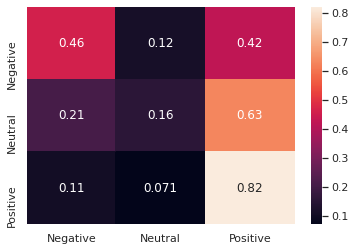

model validation accuracy is: 0.7490864799025578


In [140]:
y_pred = final_model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1).reshape(-1,1)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_test,y_pred)
print(f'model validation accuracy is: {accuracy_score(y_test,y_pred)}')

# Summary:
LSTMs have so far been disappointing in their results.  I tried large and small models, I tried smoting data, which helped the model learn to recognize different classes in an unbalanced and rather small dataset.  I also tried downloading pretrained embeddings from the GloVe project at Stanford, but those did not produce noticeably better results.  I believe this was because so much of our vocabulary is 'twitterspeak' and does not show up in the GloVe dictionary.  Only about 3/4 of our vocabulary was represented and the rest were set to all 0s.  We lost 1/4 of our information from the tweets.  It does say something that they performed about the same as learned embeddings, and if I knew a way to find meaningful and differentiated embeddings for the remaining 1232 words that GloVe was not able to encode, it may further improve the model's ability to learn.

In all, I do not believe an LSTM is the correct way to proceed with this dataset, and certainly not this approach to using pretrained embeddings.